In [214]:
from entsoe import EntsoePandasClient
import pandas as pd
import numpy as np
from time import strptime
from wwo_hist import retrieve_hist_data
import matplotlib.pyplot as plt
import plotly.express as px
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# Собираем данные по генерации

In [2]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
def getGeneratedWind(start, end):
    """
    start = 'dd-mmm-yyyy'
    end = 'dd-mm-yyyy'

    end НЕ ВКЛЮЧАЕТСЯ в данные
    возвращает DataFrame с индексом-временем и столбцом: 
        сгенерированная энергия (MW)
    """
    with HiddenPrints():
        start = start[-4:] + str(strptime(start[3:-5],'%b').tm_mon).zfill(2) + start[:2]
        end = end[-4:] + str(strptime(end[3:-5],'%b').tm_mon).zfill(2) + str(int(end[:2])).zfill(2)

        start = pd.Timestamp(start, tz='Europe/Berlin')
        end = pd.Timestamp(end, tz='Europe/Berlin')
        entsoe_client = EntsoePandasClient(api_key='c9fef790-99d3-401a-9a2c-f5c3d704dd6f')

        generation_data = entsoe_client.query_generation('DE', start=start, end=end, psr_type='B19')

        generation = pd.DataFrame(generation_data['Wind Onshore'])
        
        try:
            dataWithIndex = generation.reset_index(level = 0).drop(columns=['Actual Consumption'])
        except:
            dataWithIndex = generation.reset_index(level = 0)
            
        dataWithIndex.columns = ['date', 'aggregated']
        dataWithIndex['date'] = pd.to_datetime(dataWithIndex['date'].astype(str).str.slice(stop=10))
        groupedData = dataWithIndex.groupby(['date']).sum()
        
        return groupedData

In [149]:
data2015to2020 = pd.read_csv('generated-from-2015-to-2020.csv', index_col=0, parse_dates=True)
data2015to2020.head()

,aggregated
date,
2015-01-01,1195167.0
2015-01-02,2366483.0
2015-01-03,1828174.0
2015-01-04,1516118.0
2015-01-05,878494.0


<AxesSubplot:xlabel='date'>

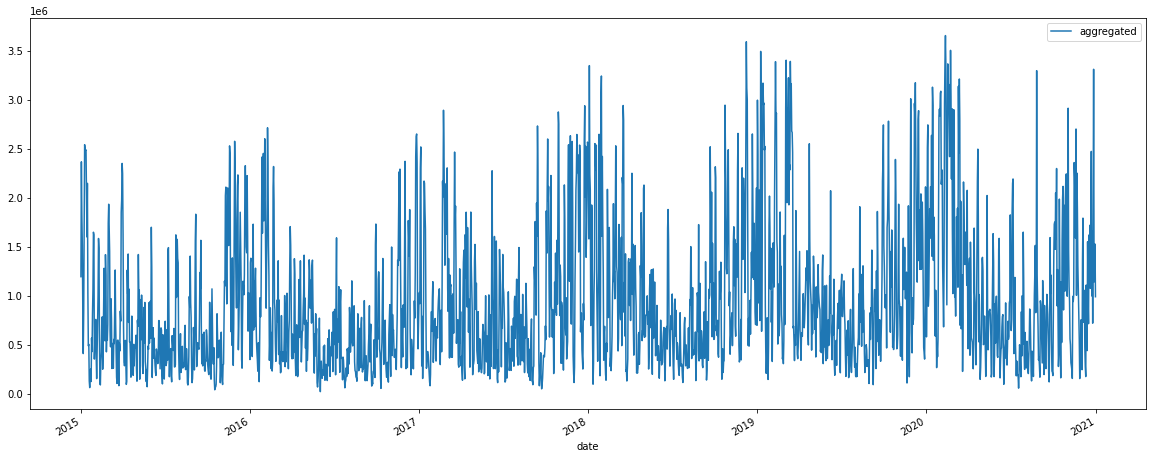

In [167]:
plt.rcParams['figure.figsize'] = (20,8)
data2015to2020[['aggregated']].plot()

# Собираем данные по скорости ветра

In [6]:
def getWindSpeed(start, end, location_list):
    """
    start = 'dd-mmm-yyyy'
    end = 'dd-mm-yyyy'
    location_list = ['loc1', 'loc2', ...]
    
    end ВКЛЮЧАЕТСЯ в данные
    возвращает DataFrame с индексом-временем и столбцом для каждого указанного города: 
        скорость ветрa (kmph)
    """
    frequency = 1
    wwo_api_key = 'a5c866d507ff491e92d195138212604'

    hist_weather_data = retrieve_hist_data(wwo_api_key, 
                                           location_list, 
                                           start, 
                                           end, 
                                           frequency, 
                                           location_label = False, 
                                           store_df = True)

    wind_speed = pd.DataFrame()
    for city, weather in zip(location_list, hist_weather_data):
        wind_speed[city + '_windspeedKmph'] = weather['windspeedKmph'].values.astype(np.float16)

    wind_speed.index = hist_weather_data[0]['date_time']
    dataWithIndex = wind_speed.reset_index(level = 0)

    dataWithIndex = dataWithIndex.rename({'date_time': 'date'}, axis=1)
    dataWithIndex['date'] = pd.to_datetime(dataWithIndex['date'].astype(str).str.slice(stop=10))
    groupedData = dataWithIndex.groupby(['date']).mean()
        
    return groupedData

In [148]:
windSpeed = pd.read_csv('windSpeed-from-2015-to-2020.csv', index_col=0, parse_dates=True)
windSpeed.head()

,Pilsach_windspeedKmph,Emden_windspeedKmph,Renkenberge_windspeedKmph,Korschenbroich_windspeedKmph,Rositz_windspeedKmph
date,,,,,
2015-01-01,5.750000,31.25,25.330,17.170,10.50
2015-01-02,14.958333,40.22,30.880,23.700,21.45
2015-01-03,11.125000,30.38,22.580,14.250,21.92
2015-01-04,18.875000,24.62,18.330,14.836,20.67
2015-01-05,13.083333,19.92,15.664,11.164,18.95


# Объединям данные

In [147]:
generation_and_speed = data2015to2020.join([windSpeed])
generation_and_speed.head()

,aggregated,Pilsach_windspeedKmph,Emden_windspeedKmph,Renkenberge_windspeedKmph,Korschenbroich_windspeedKmph,Rositz_windspeedKmph
date,,,,,,
2015-01-01,1195167.0,5.750000,31.25,25.330,17.170,10.50
2015-01-02,2366483.0,14.958333,40.22,30.880,23.700,21.45
2015-01-03,1828174.0,11.125000,30.38,22.580,14.250,21.92
2015-01-04,1516118.0,18.875000,24.62,18.330,14.836,20.67
2015-01-05,878494.0,13.083333,19.92,15.664,11.164,18.95


# Создадим аналогично тестовые данные

In [150]:
test_generation_and_speed = pd.read_csv('test_JAN-2021.csv', index_col=0, parse_dates=True)
test_generation_and_speed.head()

,aggregated,Pilsach_windspeedKmph,Emden_windspeedKmph,Renkenberge_windspeedKmph,Korschenbroich_windspeedKmph,Rositz_windspeedKmph
date,,,,,,
2021-01-01,269819.0,4.543,9.336,9.875,9.540,4.457
2021-01-02,290113.0,9.540,6.957,8.250,7.000,6.875
2021-01-03,1325659.0,4.082,18.300,16.450,12.836,13.375
2021-01-04,1091045.0,6.082,28.300,27.580,18.800,6.793
2021-01-05,924545.0,10.336,22.550,21.080,15.914,9.375


# Линейная регрессия

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
linearRegressionModel = LinearRegression()

In [12]:
actualAggregated = generation_and_speed['aggregated'].values
windspeedKmph = generation_and_speed['Pilsach_windspeedKmph'].values.reshape(-1, 1)

In [13]:
linearRegressionModel.fit(windspeedKmph, actualAggregated)

LinearRegression()

In [14]:
testwindspeedKmph = test_generation_and_speed['Pilsach_windspeedKmph'].values.reshape(-1, 1)

In [15]:
predictions = linearRegressionModel.predict(testwindspeedKmph)

## MAE, MAPE

In [176]:
MAE = mean_absolute_error(test_generation_and_speed['aggregated'].values, predictions)
MAPE = mean_absolute_percentage_error(test_generation_and_speed['aggregated'].values, predictions)
CV_MAE = cross_val_score(linearRegressionModel, 
                         windspeedKmph, 
                         actualAggregated, 
                         scoring='neg_mean_absolute_error', 
                         cv=TimeSeriesSplit(n_splits=5)).mean()
CV_MAPE = cross_val_score(linearRegressionModel, 
                         windspeedKmph, 
                         actualAggregated, 
                         scoring='neg_mean_absolute_percentage_error', 
                         cv=TimeSeriesSplit(n_splits=5)).mean()

In [211]:
print(tabulate(
    [
        ['MAE', MAE_mult], 
        ['MAPE', MAPE_mult],
        ['CV(MAE)', CV_MAE_mult],
        ['CV(MAPE)', CV_MAPE_mult]
    ], 
    headers=['Метрика', 'Лplt.figure(figsize=(20,8))
plt.plot(test_generation_and_speed['aggregated'].values, label='Actual aggregated energy')
plt.plot(predictions, label='Linear regression')
plt.legend(prop={'size': 14})
plt.title('MAE: {:.4f}, MAPE: {:.4f}, CV(MAE): {:.4f}, CV(MAPE): {:.4f}'.format(MAE, MAPE, CV_MAE, CV_MAPE))
plt.savefig('LINEAR REGRESSION.PNG')ин. регр.'],
    floatfmt=".4f"))

Метрика      Лин. регр.
---------  ------------
MAE         362958.3719
MAPE             0.3172
CV(MAE)    -300546.7691
CV(MAPE)        -0.3881


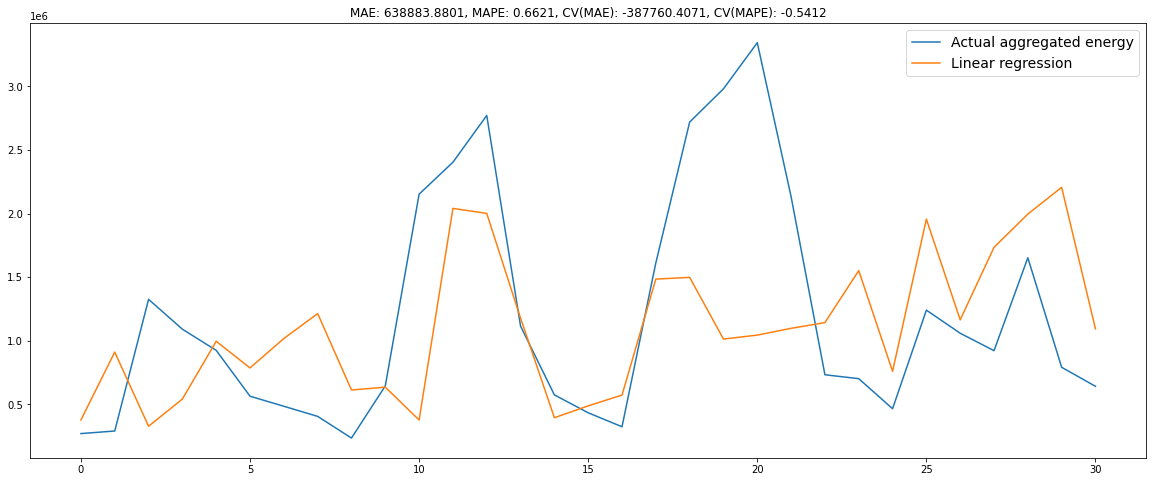

In [213]:
plt.figure(figsize=(20,8))
plt.plot(test_generation_and_speed['aggregated'].values, label='Actual aggregated energy')
plt.plot(predictions, label='Linear regression')
plt.legend(prop={'size': 14})
plt.title('MAE: {:.4f}, MAPE: {:.4f}, CV(MAE): {:.4f}, CV(MAPE): {:.4f}'.format(MAE, MAPE, CV_MAE, CV_MAPE))
plt.savefig('LINEAR REGRESSION.PNG')

# Множественная линейная регрессия

In [78]:
actualAggregatedMult = generation_and_speed['aggregated'].values
windspeedKmphMult = generation_and_speed.loc[:, generation_and_speed.columns != 'aggregated'].values

In [79]:
linearRegressionModelMult = LinearRegression()

In [80]:
linearRegressionModelMult.fit(windspeedKmphMult, actualAggregatedMult)

LinearRegression()

In [81]:
testwindspeedKmphMult = test_generation_and_speed.loc[:, test_generation_and_speed.columns != 'aggregated'].values

In [82]:
predictionsMult = linearRegressionModelMult.predict(testwindspeedKmphMult)

## MAE, MAPE

In [182]:
MAE_mult = mean_absolute_error(test_generation_and_speed['aggregated'].values, predictionsMult)
MAPE_mult = mean_absolute_percentage_error(test_generation_and_speed['aggregated'].values, predictionsMult)
CV_MAE_mult = cross_val_score(linearRegressionModelMult, 
                              windspeedKmphMult, 
                              actualAggregatedMult, 
                              scoring='neg_mean_absolute_error', 
                              cv=TimeSeriesSplit(n_splits=5)).mean()
CV_MAPE_mult = cross_val_score(linearRegressionModelMult, 
                              windspeedKmphMult, 
                              actualAggregatedMult, 
                              scoring='neg_mean_absolute_percentage_error', 
                              cv=TimeSeriesSplit(n_splits=5)).mean()

In [207]:
print(tabulate(
    [
        ['MAE', MAE_mult], 
        ['MAPE', MAPE_mult],
        ['CV(MAE)', CV_MAE_mult],
        ['CV(MAPE)', CV_MAPE_mult]
    ], 
    headers=['Метрика', 'Множ. лин. регр.'],
    floatfmt=".4f"))

Метрика      Множ. лин. регр.
---------  ------------------
MAE               362958.3719
MAPE                   0.3172
CV(MAE)          -300546.7691
CV(MAPE)              -0.3881


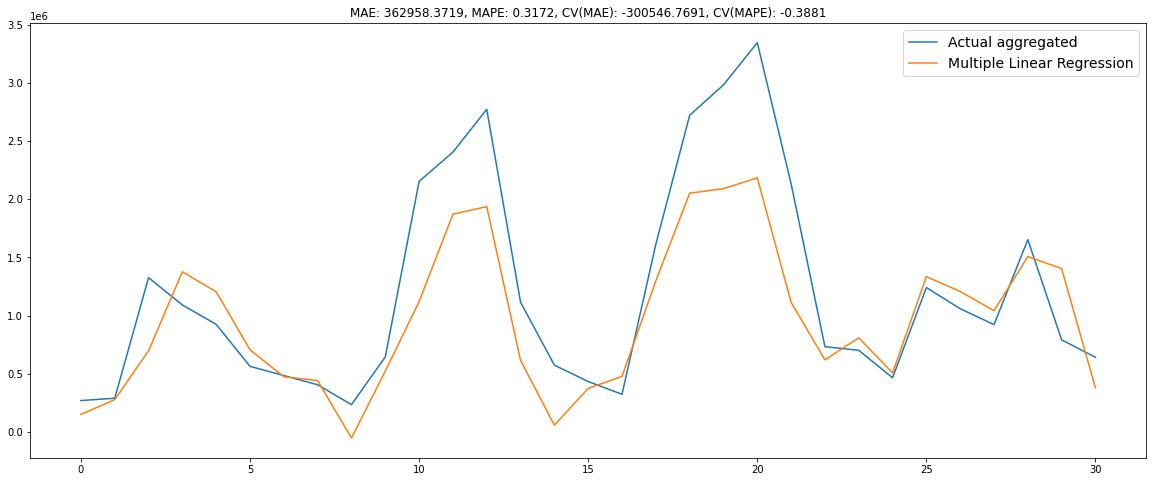

In [215]:
plt.figure(figsize=(20,8))
plt.plot(test_generation_and_speed['aggregated'].values, label='Actual aggregated')
plt.plot(predictionsMult, label='Multiple Linear Regression')
plt.legend(prop={'size': 14})
plt.title('MAE: {:.4f}, MAPE: {:.4f}, CV(MAE): {:.4f}, CV(MAPE): {:.4f}'.format(MAE_mult, MAPE_mult, CV_MAE_mult, CV_MAPE_mult))
plt.savefig('MULTIPLE LINEAR REGRESSION.PNG')

# Авторегрессия

In [31]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [32]:
generatedAuto = pd.read_csv('generated-from-2015-to-2020.csv', index_col=0, parse_dates=True)

## 1. Преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.149748
Критерий Дики-Фуллера: p=0.000010


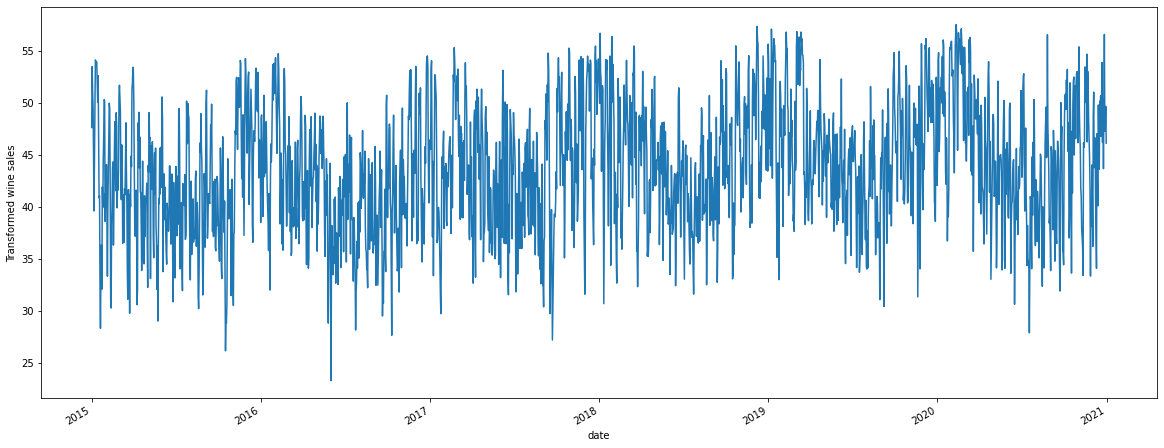

In [34]:
generatedAuto['aggregated_box'], lmbda = boxcox(generatedAuto['aggregated'])
generatedAuto['aggregated_box'].plot(figsize=(20,8))
plt.ylabel('Transformed wine sales')
print('Оптимальный параметр преобразования Бокса-Кокса: %f' % lmbda)
print('Критерий Дики-Фуллера: p=%f' % adfuller(generatedAuto['aggregated_box'])[1])

По критерию Дики-Фуллера ряд уже можно считать стационарным, но тут явно есть сезонность, для определения порядка сезонности проведём дифференцирование

## 2. Сезонное дифференцирование

Критерий Дики-Фуллера: p=0.000000


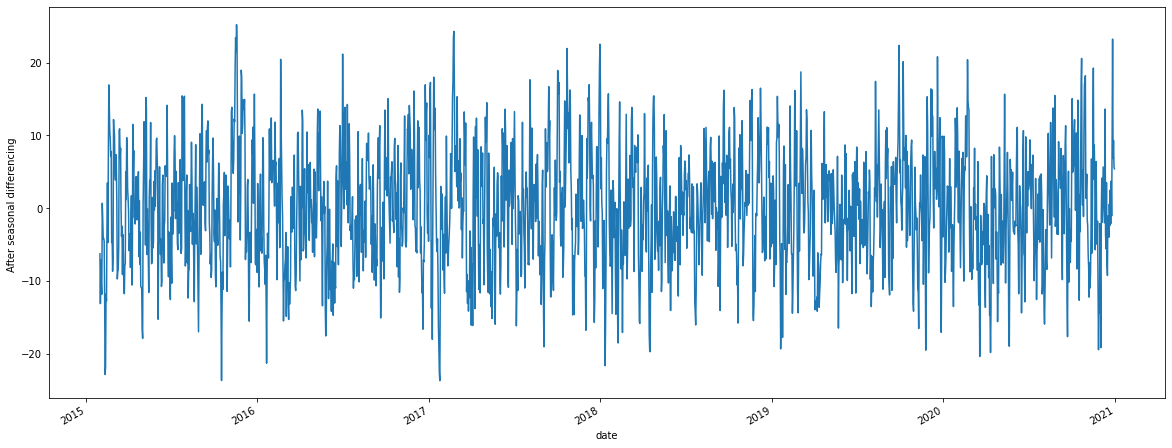

In [35]:
generatedAuto['aggregated_box_sdiff'] = generatedAuto['aggregated_box'].diff(30)
generatedAuto['aggregated_box_sdiff'].plot(figsize=(20,8))
plt.ylabel('After seasonal differencing ')
print('Критерий Дики-Фуллера: p=%f' % adfuller(generatedAuto['aggregated_box_sdiff'].dropna())[1])

Теперь будем выбирать гиперпараметры модели

## 3. Выбор гиперпараметров модели

Для выбора порядка скользящего среднего обратимся к коррелограмме.

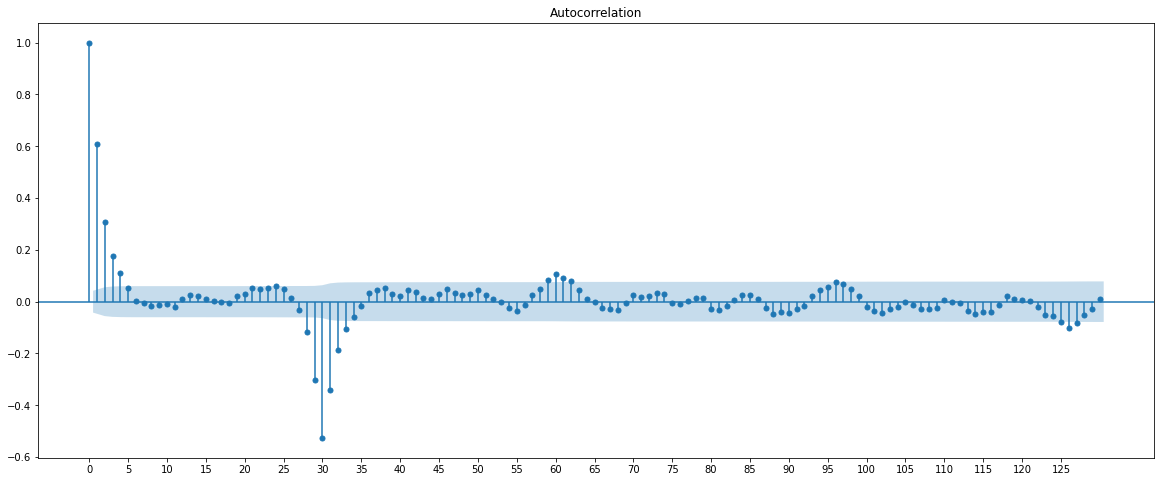

In [36]:
plt.rcParams['figure.figsize'] = (20,8)
plot_acf(generatedAuto['aggregated_box_sdiff'].dropna(), lags=130)
plt.xticks(np.arange(0, 130, 5))
plt.show()

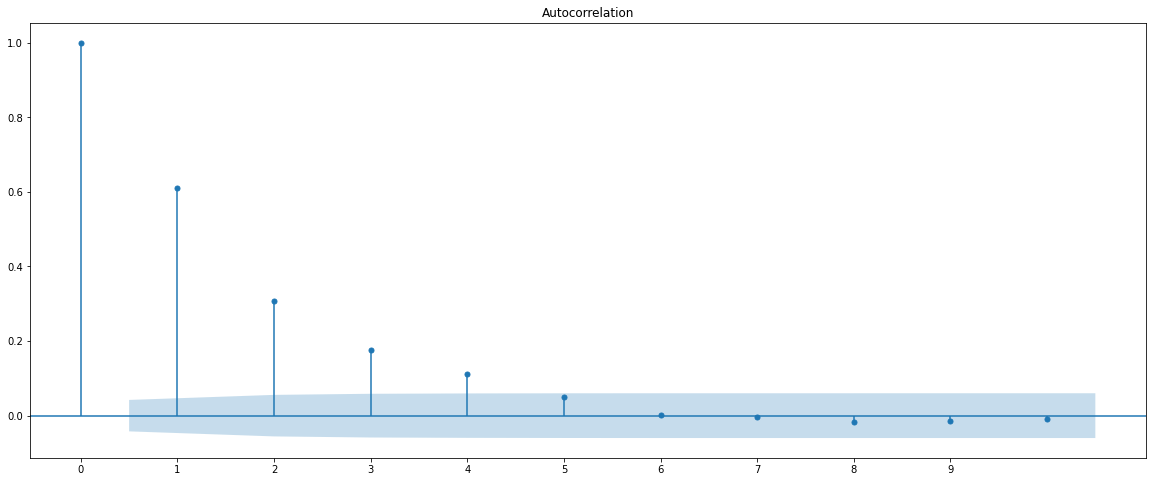

In [37]:
plt.rcParams['figure.figsize'] = (20,8)
plot_acf(generatedAuto['aggregated_box_sdiff'].dropna(), lags=10)
plt.xticks(np.arange(0, 10, 1))
plt.show()

Последний значимый лаг равен 4. А последний значимый сезонный лаг равен 2 (лаг 30\*2). Таким образом, $q_0=4, Q_0=2$.

Для выбора порядка авторегрессии обратимся к частичной автокорреляции.

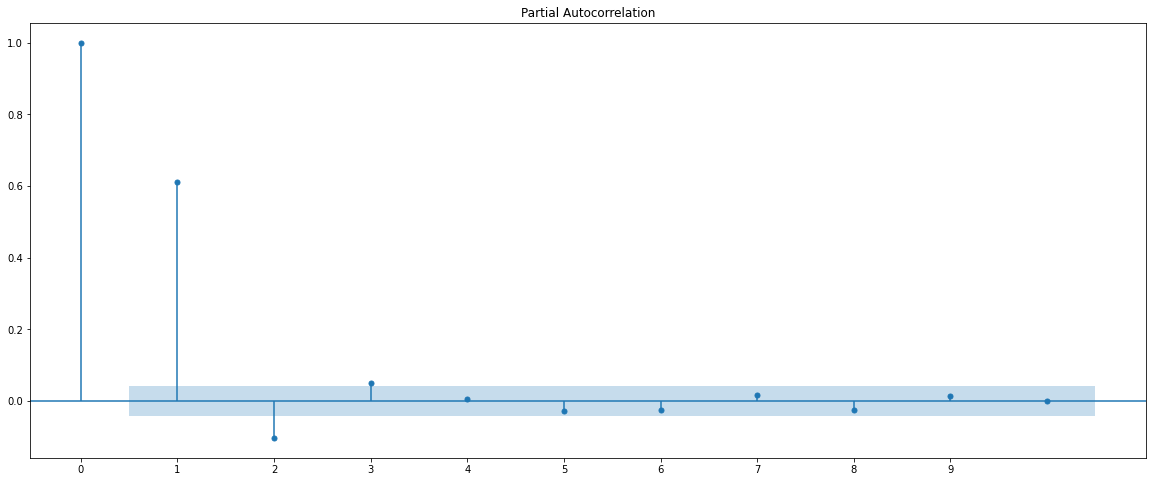

In [38]:
plt.rcParams['figure.figsize'] = (20,8)
plot_pacf(generatedAuto['aggregated_box_sdiff'].dropna(), lags=10)
plt.xticks(np.arange(0, 10, 1))
plt.show()

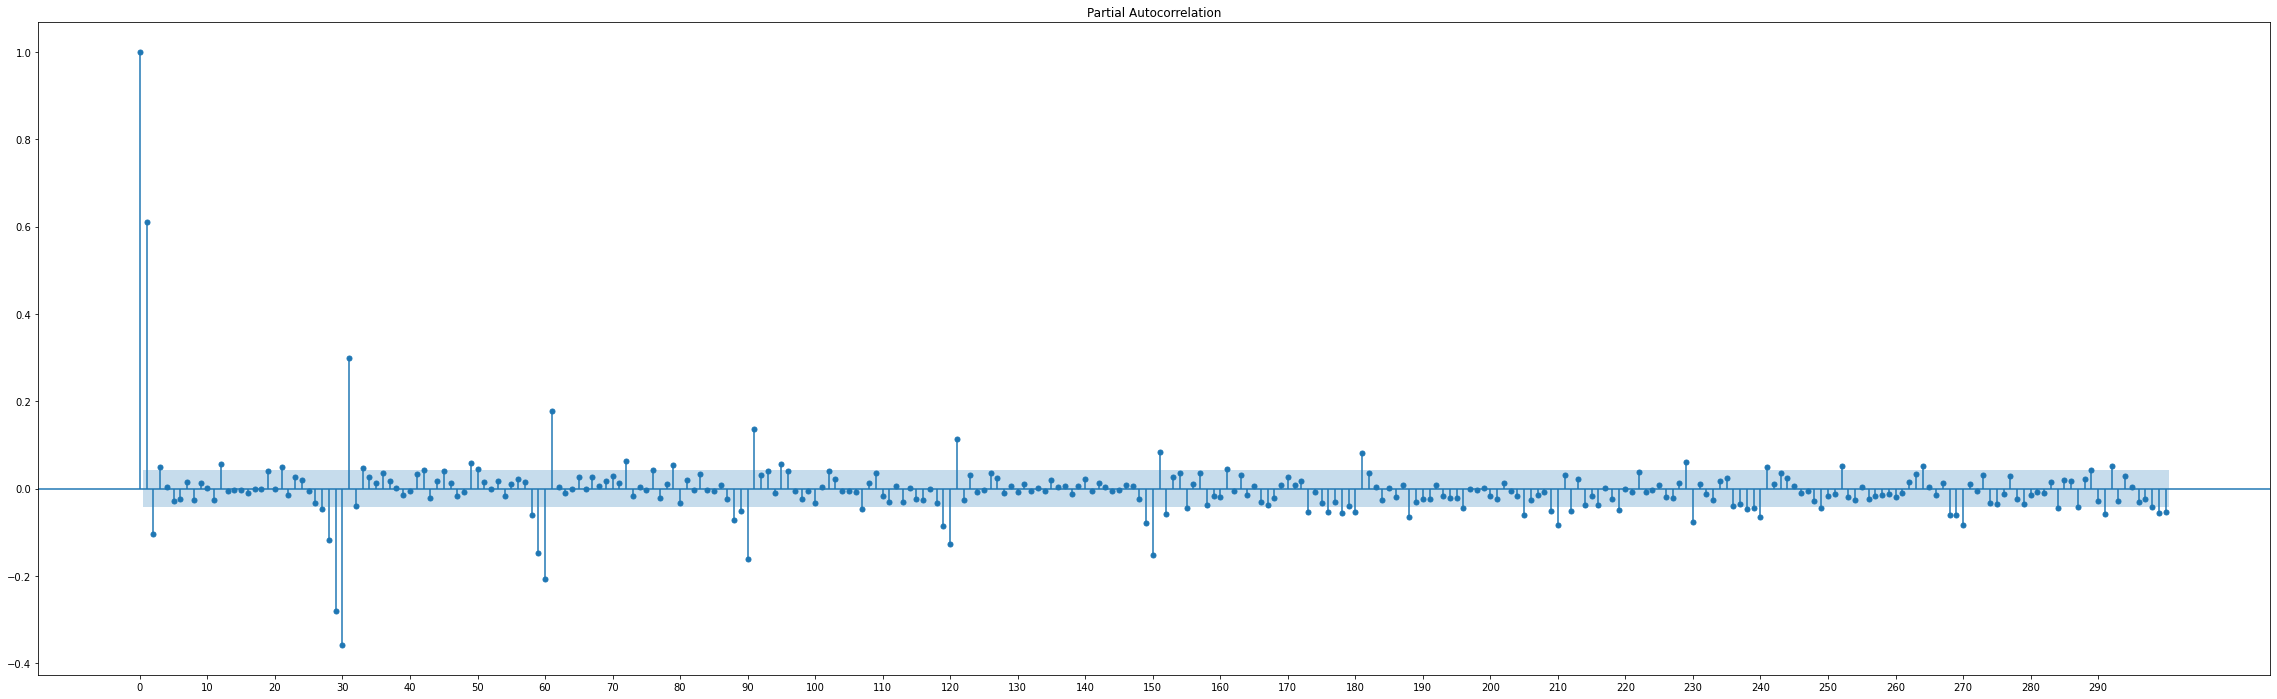

In [39]:
plt.rcParams['figure.figsize'] = (40,12)
plot_pacf(generatedAuto['aggregated_box_sdiff'].dropna(), lags=300)
plt.xticks(np.arange(0, 300, 10))
plt.show()

Последний значимый лаг оказался равным 3, значит $p_0=3$. А последний значимый сезонный лаг равен >10 (лаг 30), но, вероятно, разумнее будет взять значение от 2 до 3. Таким образом, $p_0=3, P_0=2, 3$.

In [118]:
generatedAuto = generatedAuto.asfreq(freq='D')

In [119]:
model = SARIMAX(generatedAuto['aggregated_box'],
                order=(3, 0, 4),
                seasonal_order=(3, 1, 2, 30)).fit(maxiter=20)
aic = model.aic

/Users/cmlimm/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [120]:
aic

12711.762493830953

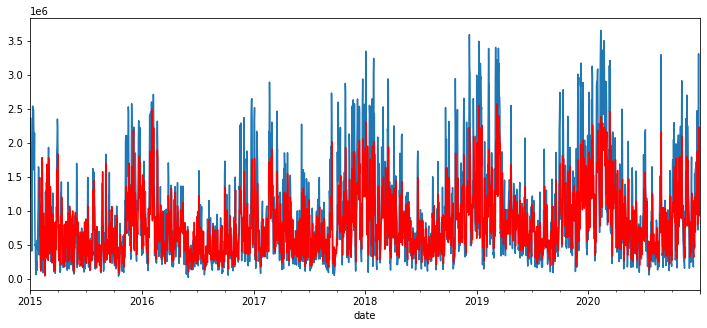

In [121]:
generatedAuto['model'] = inv_boxcox(model.fittedvalues, lmbda)
generatedAuto['aggregated'].plot(figsize=(12,5))
generatedAuto.model[30:].plot(color='r')
plt.show()

In [122]:
predictionsSARIMA = inv_boxcox(model.predict(start=pd.to_datetime('01-JAN-2021'),
                                             end=pd.to_datetime('31-JAN-2021')), 
                               lmbda)

## MAE, MAPE

In [190]:
MAE_SARIMA = mean_absolute_error(test_generation_and_speed['aggregated'].values, 
                                predictionsSARIMA.values)
MAPE_SARIMA = mean_absolute_percentage_error(test_generation_and_speed['aggregated'].values, 
                                             predictionsSARIMA.values)

In [216]:
print(tabulate(
    [
        ['MAE', MAE_SARIMA], 
        ['MAE', MAPE_SARIMA]
    ], 
    headers=['Метрика', 'SARIMA'],
    floatfmt=".4f"))

Метрика         SARIMA
---------  -----------
MAE        695043.9262
MAE             0.7378


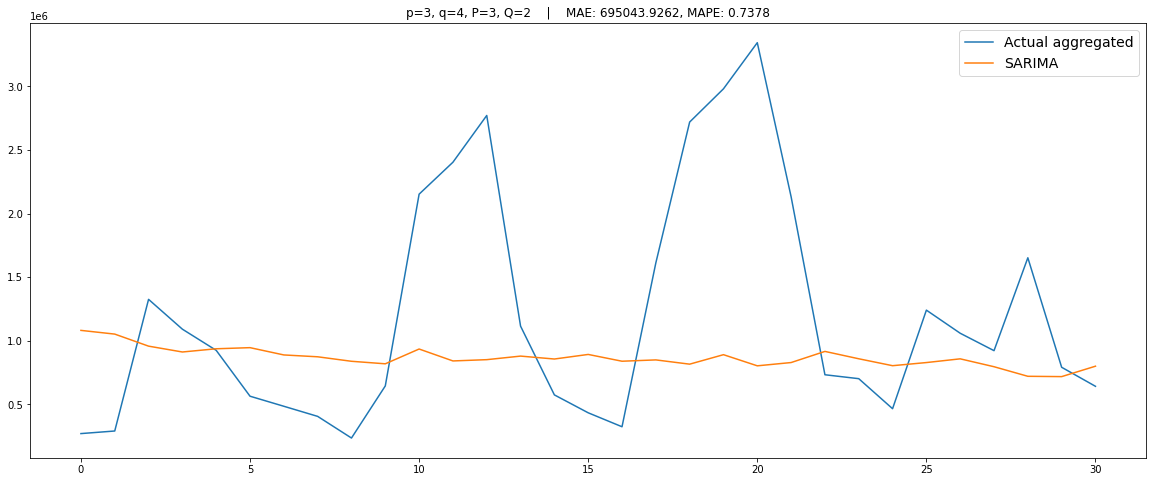

In [230]:
plt.figure(figsize=(20,8))
plt.plot(test_generation_and_speed['aggregated'].values, label='Actual aggregated')
plt.plot(predictionsSARIMA.values, label='SARIMA')
plt.title('p=3, q=4, P=3, Q=2    |    MAE: {:.4f}, MAPE: {:.4f}'.format(MAE_SARIMA, MAPE_SARIMA))
plt.legend(prop={'size': 14})
plt.savefig('SARIMA.PNG')

# Авторегрессия с экзогенными переменными

In [127]:
generation_and_speed = generation_and_speed.asfreq(freq='D')

In [45]:
model_exog = SARIMAX(endog=generatedAuto['aggregated_box'],
                     exog=generation_and_speed.loc[:, generation_and_speed.columns != 'aggregated'],
                     order=(3, 0, 4),
                     seasonal_order=(3, 1, 2, 30)).fit(maxiter=20)
aic_exog = model_exog.aic

/Users/cmlimm/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



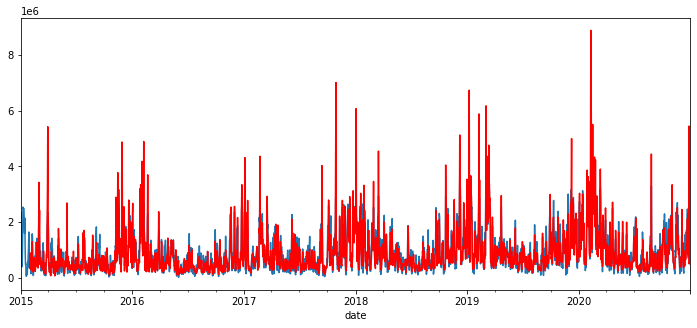

In [47]:
generation_and_speed['aggregated'].plot(figsize=(12,5))
inv_boxcox(model_exog.fittedvalues, lmbda)[30:].plot(color='r')
plt.show()

In [50]:
predictionsSARIMAX = inv_boxcox(model_exog.predict(exog=test_generation_and_speed.loc[:, test_generation_and_speed.columns != 'aggregated'],
                                                   start=pd.to_datetime('01-JAN-2021'),
                                                   end=pd.to_datetime('31-JAN-2021')), 
                                lmbda)

## MAE, MAPE

In [194]:
MAE_SARIMAX = mean_absolute_error(test_generation_and_speed['aggregated'].values, 
                                  predictionsSARIMAX.values)
MAPE_SARIMAX = mean_absolute_percentage_error(test_generation_and_speed['aggregated'].values, 
                                              predictionsSARIMAX.values)

In [195]:
print('MAE: {} \nMAPE: {}'.format(MAE_SARIMAX, 
                                  MAPE_SARIMAX))

MAE: 259543.23022825844 
MAPE: 0.3386931461980729


In [223]:
print(tabulate(
    [
        ['MAE', MAE_SARIMAX], 
        ['MAPE', MAPE_SARIMAX]
    ], 
    headers=['Метрика', 'SARIMAX'],
    floatfmt=".4f"))

Метрика        SARIMAX
---------  -----------
MAE        259543.2302
MAPE            0.3387


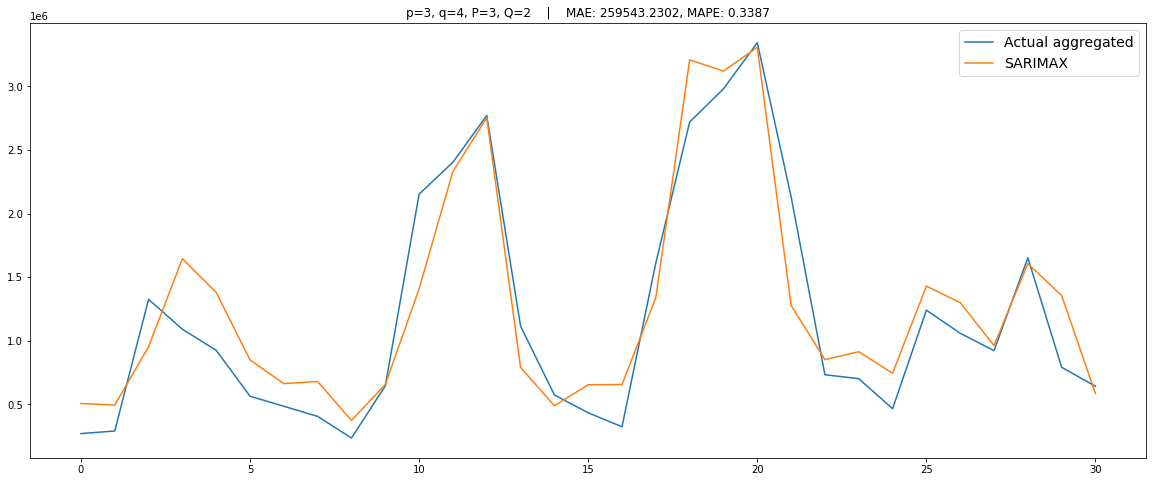

In [231]:
plt.figure(figsize=(20,8))
plt.plot(test_generation_and_speed['aggregated'].values, label='Actual aggregated')
plt.plot(predictionsSARIMAX.values, label='SARIMAX')
plt.title('p=3, q=4, P=3, Q=2    |    MAE: {:.4f}, MAPE: {:.4f}'.format(MAE_SARIMAX, MAPE_SARIMAX))
plt.legend(prop={'size': 14})
plt.savefig('SARIMAX.PNG')

# Prophet

In [70]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [155]:
generatedProphet = generatedAuto[['aggregated_box']]
generatedProphet = generatedProphet.reset_index()
generatedProphet.columns = ['ds', 'y']
generatedProphet = generatedProphet.join(
    generation_and_speed.loc[:, generation_and_speed.columns != 'aggregated'].reset_index(drop=True)
)
generatedProphet.head()

,ds,y,Pilsach_windspeedKmph,Emden_windspeedKmph,Renkenberge_windspeedKmph,Korschenbroich_windspeedKmph,Rositz_windspeedKmph
0,2015-01-01,47.612530,5.750000,31.25,25.330,17.170,10.50
1,2015-01-02,53.460218,14.958333,40.22,30.880,23.700,21.45
2,2015-01-03,51.180333,11.125000,30.38,22.580,14.250,21.92
3,2015-01-04,49.581221,18.875000,24.62,18.330,14.836,20.67
4,2015-01-05,45.166692,13.083333,19.92,15.664,11.164,18.95


In [156]:
modelProphet = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)

In [157]:
modelProphet.add_seasonality(name='yearly', period=365.25, fourier_order=10)
modelProphet.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [158]:
regressors = [
    'Pilsach_windspeedKmph',
    'Emden_windspeedKmph',
    'Renkenberge_windspeedKmph',
    'Korschenbroich_windspeedKmph',
    'Rositz_windspeedKmph'
]
for regressor in regressors:
    modelProphet.add_regressor(regressor)

In [159]:
modelProphet.fit(generatedProphet)

In [160]:
future = modelProphet.make_future_dataframe(periods=31, freq='D')
future = future.join(
    pd.concat([
        generation_and_speed.loc[:, generation_and_speed.columns != 'aggregated'], 
        test_generation_and_speed.loc[:, test_generation_and_speed.columns != 'aggregated']
    ]).reset_index(drop=True)
)

In [161]:
forecast = modelProphet.predict(future)

In [162]:
fittedProphet = inv_boxcox(forecast['yhat'][:-31].values, lmbda)
predictionsProphet = inv_boxcox(forecast['yhat'][-31:].values, lmbda)

In [163]:
generatedAuto['aggregatedProphet'] = fittedProphet

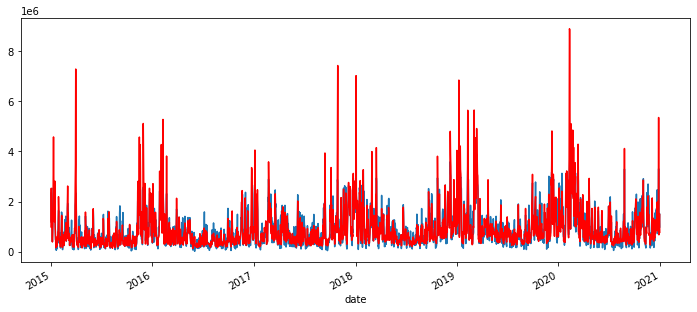

In [164]:
generation_and_speed['aggregated'].plot(figsize=(12,5))
generatedAuto['aggregatedProphet'].plot(color='r')
plt.show()

## MAE, MAPE

In [201]:
MAE_prophet = mean_absolute_error(test_generation_and_speed['aggregated'].values, 
                                 predictionsProphet)
MAPE_prophet = mean_absolute_percentage_error(test_generation_and_speed['aggregated'].values, 
                                              predictionsProphet)

In [222]:
print(tabulate(
    [
        ['MAE', MAE_prophet], 
        ['MAE', MAPE_prophet]
    ], 
    headers=['Метрика', 'SARIMA'],
    floatfmt=".4f"))

Метрика         SARIMA
---------  -----------
MAE        264771.1008
MAE             0.2979


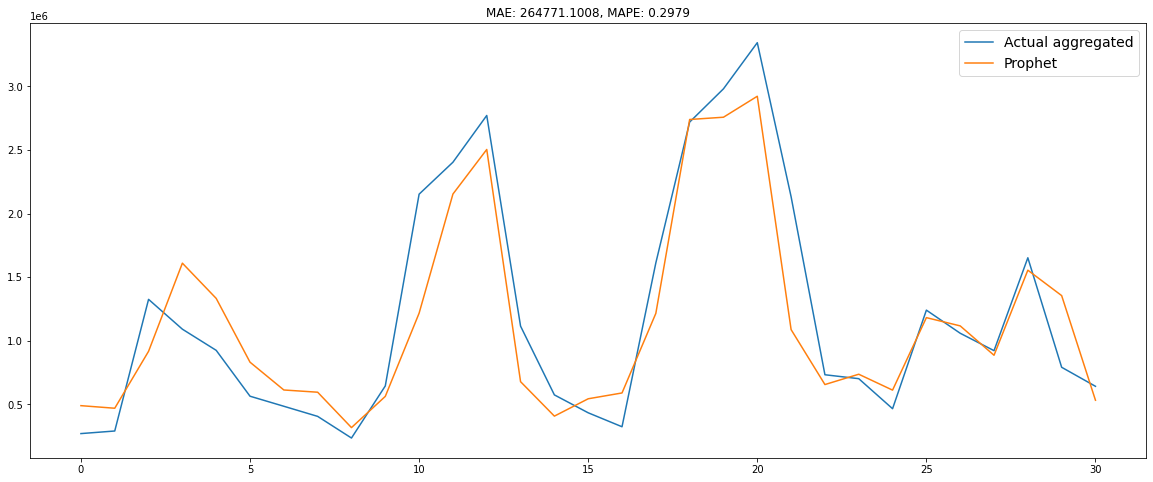

In [221]:
plt.figure(figsize=(20,8))
plt.plot(test_generation_and_speed['aggregated'].values, label='Actual aggregated')
plt.plot(predictionsProphet, label='Prophet')
plt.legend(prop={'size': 14})
plt.title('MAE: {:.4f}, MAPE: {:.4f}'.format(MAE_prophet, MAPE_prophet))
plt.savefig('PROPHET.PNG')

# Общий результат

In [203]:
print(tabulate(
    [
        ['MAE', MAE, MAE_mult, MAE_SARIMA, MAE_SARIMAX, MAE_prophet], 
        ['MAPE', MAPE, MAPE_mult, MAPE_SARIMA, MAPE_SARIMAX, MAPE_prophet]
    ], 
    headers=['Метрика', 'Лин. регр.', 'Множ. лин. регр.', 'SARIMA', 'SARIMAX', 'Prophet'],
    floatfmt=".4f"))

Метрика      Лин. регр.    Множ. лин. регр.       SARIMA      SARIMAX      Prophet
---------  ------------  ------------------  -----------  -----------  -----------
MAE         638883.8801         362958.3719  695043.9262  259543.2302  264771.1008
MAPE             0.6621              0.3172       0.7378       0.3387       0.2979


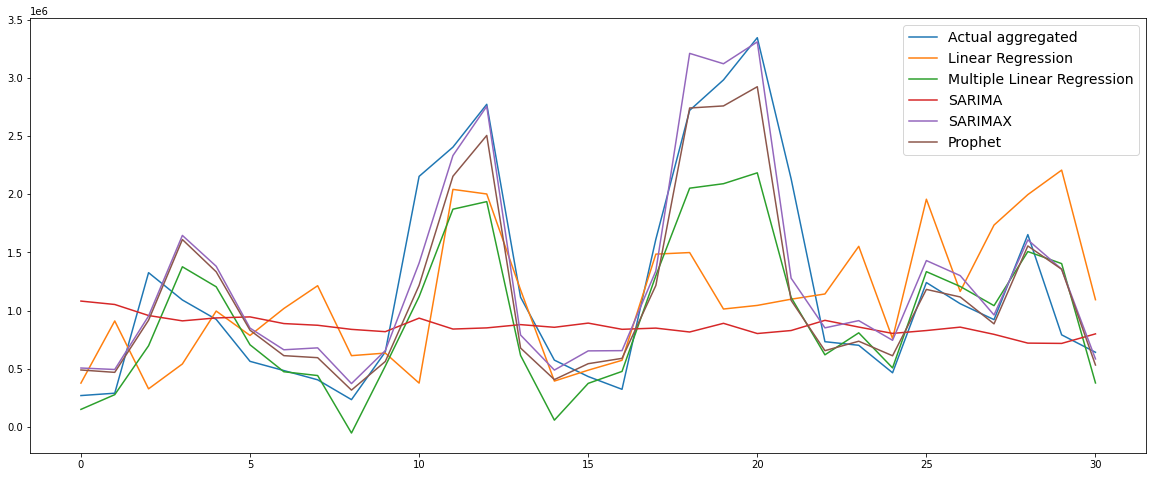

In [168]:
plt.figure(figsize=(20,8))
plt.plot(test_generation_and_speed['aggregated'].values, label='Actual aggregated')
plt.plot(predictions, label='Linear Regression')
plt.plot(predictionsMult, label='Multiple Linear Regression')
plt.plot(predictionsSARIMA.values, label='SARIMA')
plt.plot(predictionsSARIMAX.values, label='SARIMAX')
plt.plot(predictionsProphet, label='Prophet')
plt.legend(prop={'size': 14})
plt.savefig('COMPARISON.PNG')